# Sparse Sheaf Signal Processing

In [263]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from vdm import VDM
import time
from tqdm import tqdm
import zfista
import torch
import torch.nn as nn
import torch.optim as optim

### Synthetic Data

##### Point Cloud in a Cube

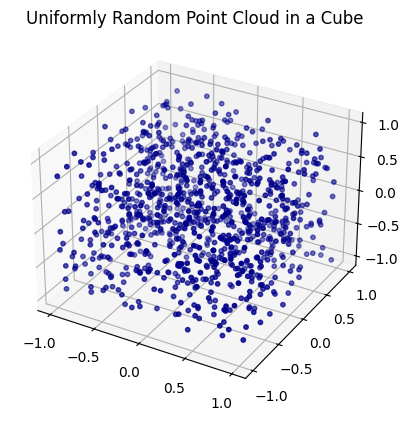

In [2]:
# Generate a cube in R^3 with uniformly random points
N = 1000 # number of points in the cloud
np.random.seed(6111983)
cube_point_cloud = np.random.uniform(-1,1,N*3).reshape((N, 3)) # points
# Plot the cube
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(cube_point_cloud[:,0], cube_point_cloud[:,1], cube_point_cloud[:,2], marker='o', s=10, c='darkblue')
plt.title('Uniformly Random Point Cloud in a Cube')
plt.show()

##### Fibonacci Sphere

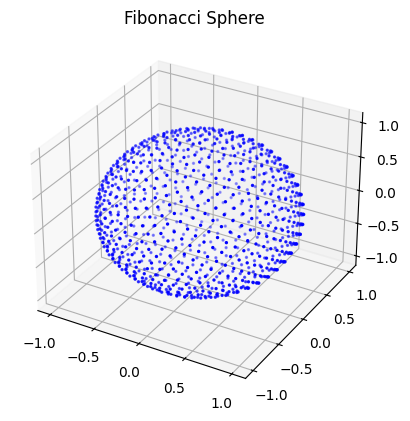

In [3]:
# Function that computes a Fibonacci Sphere
def fibonacci_sphere(N):
    i = np.arange(N)
    phi = (1+np.sqrt(5))/2
    z = 1-2*i/(N-1)
    theta = 2*np.pi*i/phi
    r = np.sqrt(1-z*z)
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    return np.column_stack((x,y,z))

N = 1000 # number of points
sphere_points = fibonacci_sphere(N)

# Plot the points
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(sphere_points[:,0], sphere_points[:,1], sphere_points[:,2], marker='o', s=2, c='blue')
plt.title('Fibonacci Sphere')
plt.show()

### Using the VDM class

##### Hyperparameters and Data

In [4]:
x = sphere_points  # DATA: cube_point_cloud or sphere_points
eps = 0.15 # epsilon for the graph
eps_pca = 0.1 # epsilon for the local PCA
k = 15 # number of neighbors in knn
gamma = 0.95 # information variability threshold in dimension estimation with singular values

##### Graph Creation

In [5]:
# Create the vdm object
vdm = VDM(x, eps, eps_pca, k, gamma)

In [6]:
# Create the graph
G = vdm.make_graph(method='radius') # method must be 'radius' or 'knn', the default is 'radius'
# 'radius': radius nearest neighbors adds an edge (i,j) if ||x[i]-x[j]|| < sqrt(eps)   -> hyperparameter eps
# 'knn': adds edges between a node and its k nearest neighbors       -> hyperparameter k

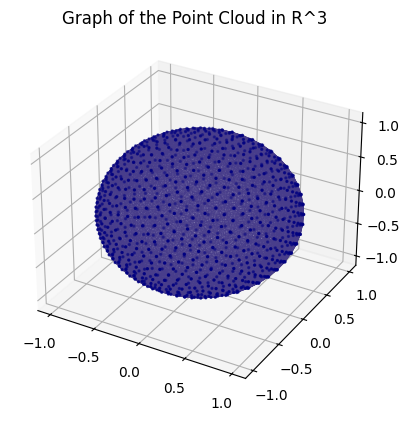

In [7]:
# Plot the points
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x[:,0], x[:,1], x[:,2], marker='o', s=2, c='navy')
# Plot the edges
for edge in G.edges():
    x1, y1, z1 = x[edge[0]]
    x2, y2, z2 = x[edge[1]]
    ax.plot([x1, x2], [y1, y2], [z1, z2], c='darkslateblue', linewidth=0.5, alpha=0.5)
plt.title('Graph of the Point Cloud in R^3')
plt.show()

##### Orthonormal Basis Approximation

In [8]:
# Approximate the orthonormal bases of the tangent vector spaces at every point
# Returns a list of orthonormal bases, with O[i] = O_i (orthonormal basis of the tangent vector space of node i)
O = vdm.make_orthonormal_bases()
O[:3] # First three orthonormal bases (for nodes 1,2,3)

[array([[-1.57088847e-01,  9.87584204e-01],
        [-9.87584469e-01, -1.57088725e-01],
        [-1.04699031e-04, -7.56417280e-04]]),
 array([[ 0.37641522,  0.92518376],
        [-0.92628464,  0.37484175],
        [-0.01755973,  0.05940257]]),
 array([[-0.45558446,  0.89014014],
        [-0.88609184, -0.45449953],
        [ 0.08534668,  0.03287402]])]

##### Alignment

In [9]:
# Compute the alignment matrices
# O_alignment is a dictionary of dictionaries with O_alignment[i][j] = O_ij = U V^T
# with U @ Sigma @ V.T singular value decomposition of O_i.T @ O_j
O_alignment = vdm.make_alignment_matrices()
node1 = 0
node2 = list(G.neighbors(node1))[0]
O_alignment[node1][node2]  # Alignment matrix between node1 and node2

array([[ 0.96164377,  0.27430139],
       [-0.27430139,  0.96164377]])

##### Vector Diffusion Mapping

In [10]:
# Compute the diffusion distance between node1 and node2 at time t=1
print(vdm.diffusion_distance(node1,node2,1))

0.9851763395587501


In [11]:
# Compute the diffusion map of point 3 at time 5   (V_t(i) for i=3, t=5)
print(vdm.vector_diffusion_mapping(3,5,p=1))
# p is the percentage of the vector that is computed because computing the whole vector might be infeasible for large N

[ 3.79756631e-04  2.96550526e-18 -8.05198681e-07 ...  3.42291871e-13
  1.92123329e-26  4.93508215e-14]


In [12]:
# Compute the vdm distance between points 0 and 432 at time t=1
print(vdm.vdm_distance(0,432,1))

0.053651957136085636


In [13]:
vector_dd = vdm.vdm_distance(0,1,1,p=0.8) # vdm distance between points 0 and 1 at time 1
print(vector_dd)
vector_dd2 = vdm.vdm_distance(0,432,1,p=0.8) # vdm distance between points 0 and 432 at time 1
print(vector_dd2)
print(np.linalg.norm(x[0]-x[1]))  # Euclidean distance between points 0 and 1
print(np.linalg.norm(x[0]-x[432]))  # Euclidean distance between points 0 and 432

0.02349746488608159
0.053651957136085636
0.06327719971683228
1.3151918984428583


In [14]:
normalized_vdm_dist = vdm.norm_vdm_distance(0,432,1,p=0.8) # normalized vdm distance between points 0 and 432 at time 1

##### Some Other Class Methods

In [15]:
d = vdm.estimate_dim() # Estimated dimension
W = vdm.get_weight_matrix() # Weight matrix
degrees = vdm.get_degree_vector() # Degree vector
S = vdm.get_alignment_block_matrix() # block matrix (S) formed by the weighted alignment matrices and zero blocks: dN x dN
D = vdm.get_kron_degree_matrix() # degree matrix (D): dN x dN with D(i,i) = deg(i) * I_{d x d}
D_cursive = vdm.get_degree_matrix() # degree matrix (D): N x N with D(i,i) = deg(i)
A = vdm.get_transition_matrix() # transition matrix (A): N x N with A = D_cursive^-1 W
S_tilde = vdm.get_affinity_matrix() # affinity matrix (S_tilde): dN x dN

##### Connection Laplacian of the Graph

In [16]:
# Connection Laplacian of the graph, computed as D^-1 @ S - I
L = vdm.connection_laplacian()
# Compute eigenvalues and eigenvectors
eigvals, eigvecs = np.linalg.eig(L)
idx = np.argsort(eigvals)
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]
eigvals

array([-1.32024001, -1.32024001, -1.31826119, ..., -0.09739255,
       -0.08771657, -0.08771657], shape=(2000,))

### Wavelets

TO-DO:

1. Compute the laplacian (sheaf laplacian or 1-simplices/edges laplacian?)
2. Laplacian eigenvalues and eigenvectors
3. Define a kernel as a parametric function R->R, choose a set of parameters
4. Define the impulse (complex conjugate of the eigenvector corresponding to a chosen node/edge)
5. The wavelet is the linear combination of the laplacian eigenvectors with weights being kernel(scale*eigenvalue) * impulse
6. Define a signal (sheaf signal is a dim=2N+2E vector, 1-simplex signal a dim=E vector, depends on the laplacian)
7. Wavelet coefficients are the inner product between wavelet and signal
8. Compute different wavelets for different parameters and make a dictionary

In [ ]:
class Wavelet:
    def __init__(self,L):
        # Laplacian and its eigendecomposition
        self.L = L
        self.eigvals = None
        self.eigvecs = None

        # kernel parameters (default values)
        self.k = 1
        self.t = 1
        self.p = 1
    
    # Kernel parameter modification
    def set_kernel_parameters(self,k,t,p):
        if k < 0:
            raise ValueError("k must be non-negative")
        if t < 0:
            raise ValueError("t must be non-negative")
        if p < 0:
            raise ValueError("p must be non-negative")
        self.k = k
        self.t = t
        self.p = p
    
    # Parametric kernel function g
    def g(self,x):
        '''
        Function that computes the parametric kernel g
        The kernel is of the form g(x) = x^k * exp(-t * x^p)
        satisfying the conditions g(0)=0 and g(x)->0 as x->+inf to serve as a bandpass filter
        '''
        return x**self.k * np.exp(-self.t * x**self.p)

    def get_eig_laplacian(self):
        '''
        Function that computes the eigendecomposition of the laplacian 
        and returns a tuple with sorted eigenvalues and eigenvectors
        L = laplacian
        '''
        eigvals, eigvecs = np.linalg.eig(self.L)
        idx = np.argsort(eigvals)
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:,idx]
        self.eigvals = eigvals
        self.eigvecs = eigvecs
        return eigvals, eigvecs
    
    # Function that ensures the eigendecomposition is computed
    def _ensure_eig_laplacian(self):
        if self.eigvals is None or self.eigvecs is None:
            self.get_eig_laplacian(self.L)

    # Function that applies the wavelet operator to a node or edge
    def wavelet(self,m,scale,shift):
        '''
        Function that applies a wavelet operator with input scale and shift parameters to a node or edge m
        Inputs:
        m = node or edge
        scale = scale parameter
        shift = shift parameter
        '''
        self._ensure_eig_laplacian()
        eigvals = self.eigvals
        eigvecs = self.eigvecs
        weights = np.multiply(self.g(scale*eigvals), eigvecs[shift])
        return np.dot(eigvecs[m], weights)
    
    # Function that returns the wavelet coefficient of a signal
    def wavelet_coef(self,f,scale,shift):
        '''
        Function that computes the wavelet coefficient of a signal f
        f = signal
        scale = scale parameter
        shift = shift parameter
        '''
        self._ensure_eig_laplacian()
        eigvals = self.eigvals
        eigvecs = self.eigvecs
        fourier_transform = eigvecs.T @ f
        weights = np.multiply(self.g(scale*eigvals), eigvecs[shift])
        return np.dot(fourier_transform, weights)
    
    # Function that builds an array of atoms for a given set of scales and shifts (wavelet dictionary)
    def make_dictionary(self, scales, shifts):
        '''
        Function that creates a dictionary of wavelets for different scales and shifts
        Inputs:
        scales = list of scales
        shifts = list of shifts
        Returns:
        dictionary = dictionary of wavelets
        '''
        self._ensure_eig_laplacian()
        num_scales = len(scales)
        num_shifts = len(shifts)
        wavelet_dict = np.zeros((self.L.shape[0],num_scales*num_shifts))
        for i, scale in tqdm(enumerate(scales)):
            spectral_scaling = self.g(self.eigvals * scale)
            for j, shift in tqdm(enumerate(shifts)):
                weights = np.multiply(spectral_scaling, self.eigvecs[shift])
                wavelet_dict[:,i*num_shifts+j] = self.eigvecs @weights 
        return wavelet_dict
    
    def sparse_signal(self,f,wav_dict):
        '''
        Function that computes the sparsest representation of a signal f
        f = signal
        wav_dict = dictionary of wavelets, optionally already implemented
        Returns:
        sparse representation of f 
        '''
        pass

##### Data

In [94]:
# Generate a cube in R^3 with uniformly random points
N = 1000 # number of points in the cloud
np.random.seed(6111983)
cube_point_cloud = np.random.uniform(-0.5,0.5,N*3).reshape((N, 3)) # points

# Generate fibonacci_sphere
N = 1000 # number of points
sphere_points = fibonacci_sphere(N)

##### VDM

In [116]:
eps = 0.15 # epsilon for the graph
eps_pca = 0.1 # epsilon for the PCA
k = 7 # number of nearest neighbors for the graph 
vdm2 = VDM(sphere_points,eps_pca,k) # VDM object
G = vdm2.make_graph(method='knn')
L = vdm2.connection_laplacian()

##### Wavelets

In [189]:
# Create a wavelet object and compute the Laplacian eigendecomposition
wav = Wavelet(L)
wav.get_eig_laplacian()

(array([-1.35487011, -1.35487011, -1.3542376 , ..., -0.07213568,
        -0.04286326, -0.04286326], shape=(2000,)),
 array([[-1.27668422e-05,  4.50590627e-08,  1.44185068e-04, ...,
         -5.14641503e-04,  3.56284896e-04, -6.54245657e-07],
        [ 6.53700359e-17,  1.27667627e-05, -7.42570726e-17, ...,
          1.14195769e-01,  3.58664289e-05,  3.58085046e-04],
        [-2.54070134e-05,  7.01967228e-05,  5.69925290e-04, ...,
          6.32302536e-02,  2.98449876e-04,  2.04019829e-04],
        ...,
        [ 1.09664580e-04,  1.31985885e-06, -1.99428238e-06, ...,
          3.11926376e-04,  9.54852187e-02, -2.96241064e-02],
        [ 6.44034305e-05, -5.51341330e-05,  7.92298315e-07, ...,
         -7.97717289e-04,  8.64540990e-02,  6.36044339e-02],
        [ 5.49071707e-05,  6.42092410e-05, -1.75124028e-05, ...,
          9.12190860e-04,  5.53706387e-02, -8.05896697e-02]],
       shape=(2000, 2000)))

In [190]:
# Number of impulses: N
# Number of scales: num_scales
# The resulting dictionary will contain num_scales*N wavelets

# Scale set
num_scales = 7
scales = [2**(j-2) for j in range(num_scales)]
# Choice logic: geometrical spacing to analyse the signals at different resolutions
# Small scales pick up on local features, larger scales on global ones

# Shift set
num_shifts = L.shape[0]
shifts = [i for i in range(num_shifts)]

# Make a dictionary from wavelets with scales in scales and shifts in [1:N]
wav_dict = wav.make_dictionary(scales,shifts)

2000it [00:07, 266.55it/s]
2000it [00:07, 283.43it/s]
2000it [00:07, 281.52it/s]
2000it [00:07, 276.31it/s]
2000it [00:06, 288.09it/s]
2000it [00:07, 280.05it/s]
2000it [00:07, 275.84it/s]
7it [00:50,  7.18s/it]


In [266]:
# Define a signal
signal = 3*wav_dict[:,0] + 5*wav_dict[:,100] - 2*wav_dict[:,200]

##### Sparse Optimization Problem

Given an overcomplete dictionary $A$ and a signal $y$, finding the best sparse representation of $y$ is equivalent to solving

$$
\min_x \|x\|_0 \quad \text{s.t.} \quad Ax=y
$$

Since this problem is NP-hard, we try to solve this problem instead:

**LASSO**

$$
\min_x \frac{1}{2} \| Ax-y \|_2^2 + \lambda \|x\|_1
$$

where

* A = wavelet dictionary
* y = signal
* x = sparse representation of the signal that we want to find
* $\lambda$ = regularization parameter